In [1]:
import pandas as pd
from IPython.display import Javascript
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
%matplotlib inline

import math
def roundup(x):
  return int(math.ceil(x / 100.0)) * 100
def rounddown(x):
  return int(math.floor(x / 100.0)) * 100

from google.colab import drive
drive.mount('/content/drive')


dark_blue = "#263f96"
light_blue= '#43B0F1'
lighter_blue = '#c8d9ed'
light_red= '#D43790'
light_orange = '#F79862'
red ='#EA1313'

pd.set_option('precision', 4)

params = {'legend.fontsize': 'x-large',          
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
       
pd.set_option('display.max_rows', 200)         
plt.rcParams.update(params)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## DATA EXPLORATION


### Exploration of the LAA dataset. Number of slices distribution (Histogram)

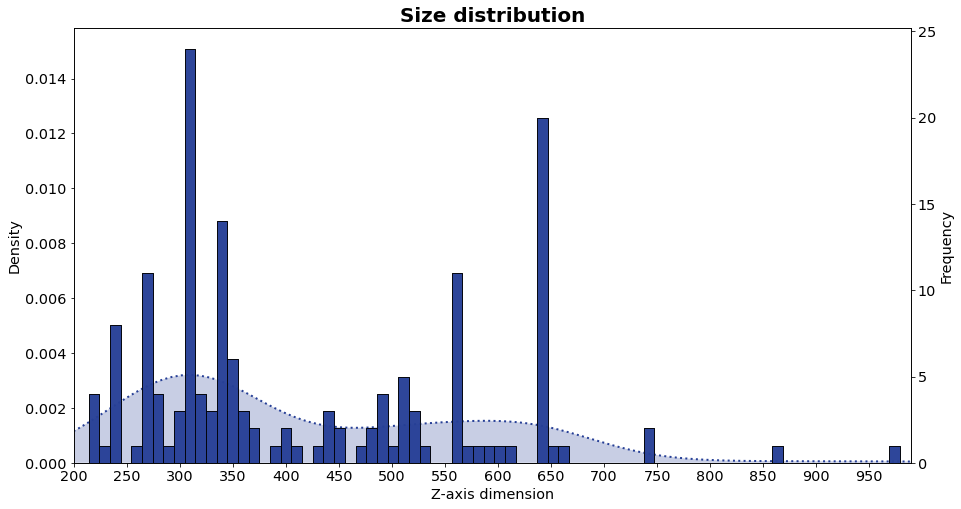

In [2]:
figures_data = pd.read_csv('/content/drive/My Drive/TFM/Data_models_TFM/LAA/Figure_variation_forhist.csv')
fig, ax1 = plt.subplots(figsize = (15,8))
# sns.distplot( x= 'frequency', y = 'value', data =figures_data, orient ='h' ,palette="Blues_d")
bins_num = set(figures_data["value"])
ax2 = ax1.twinx()

sns.distplot(figures_data["value"], kde=False,rug=False,norm_hist=False, bins= len(bins_num),ax = ax2,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},vertical=False,
               kde_kws={"color": dark_blue , "lw": 2,"linestyle" : ':',"shade": True},
               hist_kws={"histtype": "barstacked", "linewidth": 1,"alpha": 0.8, "color": dark_blue, 'edgecolor':'k'})

sns.distplot(figures_data["value"], kde=True,rug=False,norm_hist=False, bins= len(bins_num),ax = ax1,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},vertical=False,
               kde_kws={"color": dark_blue , "lw": 2,"linestyle" : ':',"shade": True},
               hist_kws={"histtype": "barstacked", "linewidth": 1,"alpha": 0.8, "color": dark_blue, 'edgecolor':'k'})

ax2.set_title('Size distribution',fontweight='bold',fontsize = 20);
ax2.set(xlim=(figures_data.value.min()-10, figures_data.value.max()+10))
ax2.set_xlabel('Z-axis dimension')
ax1.set_xlabel('Z-axis dimension')

ax2.set_ylabel('Frequency')
ax1.set_ylabel('Density')
ax2.xaxis.set_ticks(np.arange(rounddown(figures_data.value.min()), roundup(figures_data.value.max()), 50))
ax1.xaxis.set_ticks(np.arange(rounddown(figures_data.value.min()), roundup(figures_data.value.max()), 50));


## TRAINING

### [Training] Current State of the Networks

Display the current state of the networks. Info is extracted from the stat.json that the Networks regularly update. Weighted update is a dummy plot that just takes into account the overall performance of the network:

- __Score:__ How well the agent is doing during the evaluation. Considers distance to the target landmark and also the time required to do so.
- __Succes ratio:__ Wether the agent was able to find the landmark before reaching the maximum number of frames allowed
- __Mean distance :__ The mean distance to the landmark achieved. 
- __Max distance:__ The maximum distance to the landmark achieved. 

In [24]:

lm_names = ['Circumflex','Landing Zone', 'Ostium']
models_names = {0:['default','spacing4','ND_default'],
                1:['default','ND_default'],    
                2:['default','ND_default']}

num = 2 # Landmark number
indx = 1 # Number of try
windowsize = 10
centered = True
filepath = f'/content/drive/My Drive/TFM/Data_models_TFM/LAA/LM_{num:02d}/{models_names[num][indx]}/stats.json'

print(filepath)
data = pd.read_json(path_or_buf= filepath,orient='records') 

my_df = data[['epoch_num','n_success_ratio','mean_score','mean_distance','max_distance','global_step',
              'expreplay/mean_score',	'expreplay/max_score',	'expreplay/mean_dist',	'expreplay/max_dist','huber_loss/value','QueueInput/queue_size']].copy()

my_df['weighted_value'] = my_df.apply(lambda row: 100*row.n_success_ratio**2/((row.mean_distance*row.iloc[10])*(row.max_distance**2)), axis=1)

my_df['rolling_w_v'] = my_df['weighted_value'].rolling(window=windowsize, min_periods=windowsize//2,center=centered).mean()
my_df.set_index('epoch_num')
my_df.tail(10)

/content/drive/My Drive/TFM/Data_models_TFM/LAA/LM_02/ND_default/stats.json


,epoch_num,n_success_ratio,mean_score,mean_distance,max_distance,global_step,expreplay/mean_score,expreplay/max_score,expreplay/mean_dist,expreplay/max_dist,huber_loss/value,QueueInput/queue_size,weighted_value,rolling_w_v
63,64,0.9920,35.4650,15.7083,19.1465,1600000,72.4456,181.8307,0.7142,8.8078,0.0564,0.7857,0.3032,0.3318
64,65,0.9932,NaN,NaN,NaN,1625000,72.7712,184.5040,0.7361,73.2559,0.0517,0.7646,NaN,0.3318
65,66,0.9936,32.3996,15.7029,19.1465,1650000,71.7351,179.5755,0.7125,9.2109,0.0457,0.7535,0.3755,0.3595
66,67,0.9907,NaN,NaN,NaN,1675000,71.5199,178.5233,0.7243,9.1016,0.0555,1.0042,NaN,0.3595
67,68,0.9885,31.5054,15.6121,19.1465,1700000,73.4128,203.8648,0.7058,23.2552,0.0406,0.7666,0.4205,0.3605
68,69,0.9940,NaN,NaN,NaN,1725000,72.3888,181.2909,0.6586,9.0234,0.0449,1.5981,NaN,0.3605
69,70,0.9937,28.7032,15.6757,19.1465,1750000,71.9377,182.8893,0.7551,47.0969,0.0475,0.3875,0.3618,NaN
70,71,0.9920,NaN,NaN,NaN,1775000,72.1974,164.5391,0.7641,9.3359,0.0473,0.0792,NaN,NaN
71,72,0.9877,32.5572,15.9492,19.1465,1800000,73.0424,178.8239,0.7381,9.2916,0.0488,1.0670,0.3416,NaN
72,73,0.9924,NaN,NaN,NaN,1825000,73.4754,177.2218,0.6788,9.4379,0.0538,0.1530,NaN,NaN


### [Training] Plotting of the DQN's json 

<IPython.core.display.Javascript object>

Current best: 02_ND_default_01_model-1700000.csv


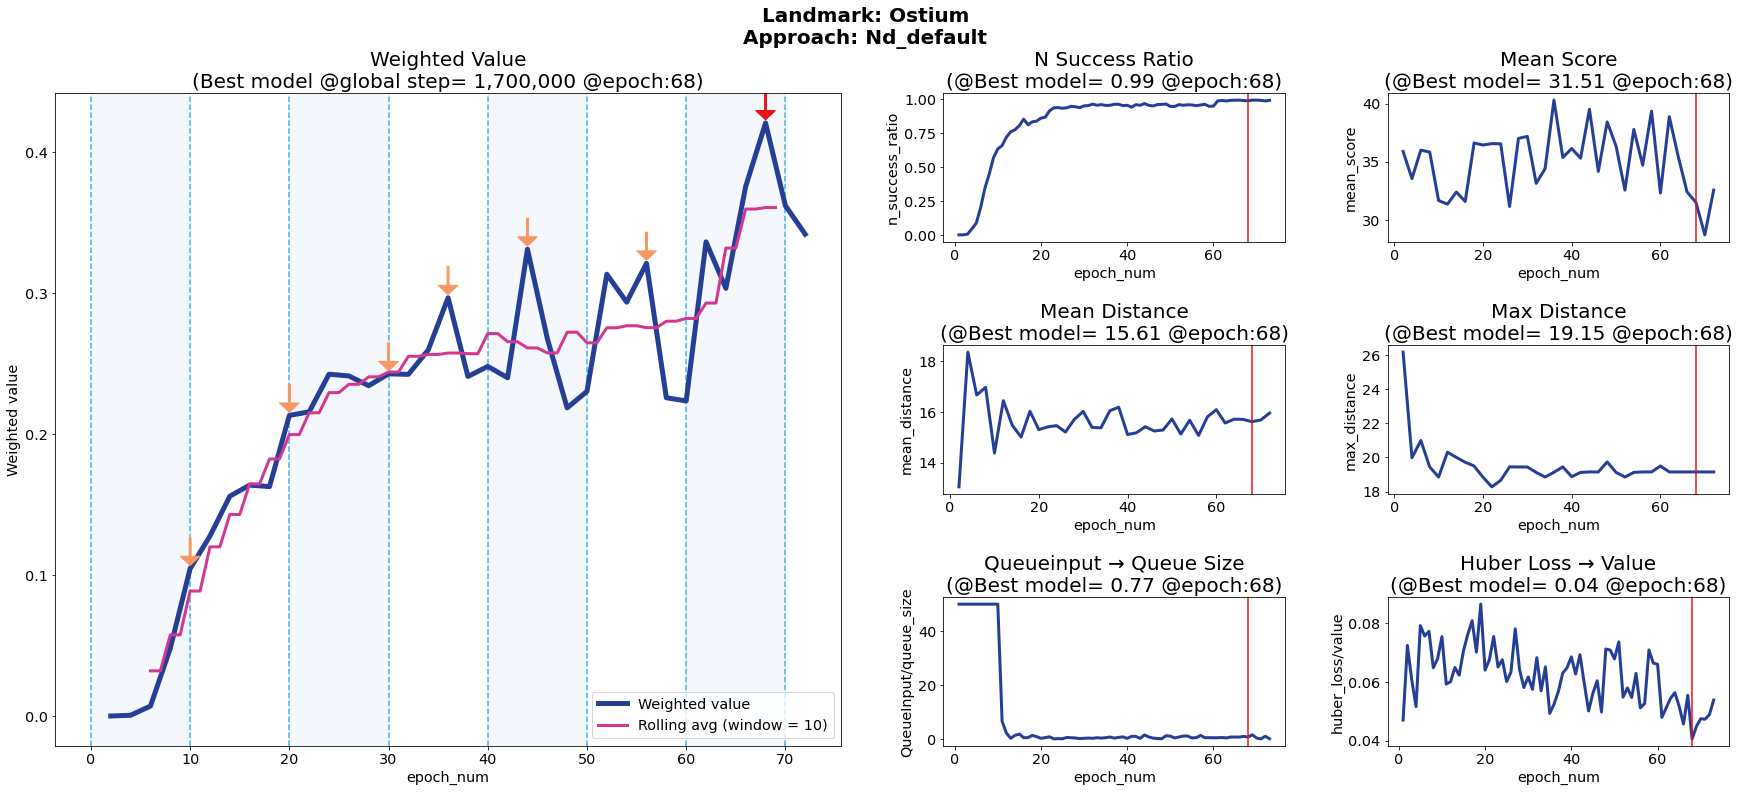

In [25]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

#Setting the subplot
fig = plt.figure(figsize = (30,12))
grid = plt.GridSpec(3, 4, hspace=.7, wspace=0.3)
arrow_symb = " "+u"\u2192"+" " 
multiax = fig.add_subplot(grid[:, :2])
ax1 = fig.add_subplot(grid[0, 2])
ax2 = fig.add_subplot(grid[0, 3])
ax3 = fig.add_subplot(grid[1, 2])
ax4 = fig.add_subplot(grid[1, 3])
ax5 = fig.add_subplot(grid[2, 2])
ax6 = fig.add_subplot(grid[2, 3])

best_mod = my_df.iloc[my_df['weighted_value'].argmax(),:] #choose best model 
columns_to_plot = ["weighted_value","n_success_ratio" ,"mean_score","mean_distance","max_distance","QueueInput/queue_size","huber_loss/value"]
group_of_best = []
current_max = np.NINF

for i, ax in enumerate(plt.gcf().get_axes()):
  if i == 0: # first plot is different
    n_group=10
    df_max = my_df.groupby(np.arange(len(my_df.index)) // n_group)[['weighted_value']].agg(['min', 'max','idxmax'])#group i
    if len(my_df)%n_group == 1:
      df_max.drop(df_max.tail(1).index,inplace=True)
      df_max.iloc[:,2] = df_max.iloc[:,2].astype('int64')
          
    wgth = sns.lineplot(x="epoch_num", y=columns_to_plot[i], data=my_df,ax= ax,color = dark_blue, zorder = -5, linewidth = 5,label = f'Weighted value')
    mvavg = sns.lineplot(x="epoch_num", y="rolling_w_v", data=my_df,ax= ax,
             color = light_red,linewidth = 3, zorder = -4,linestyle ='--',
             label =f'Rolling avg (window = {windowsize})').set_title(f"Weighted Value\n(Best model @global step= {best_mod.global_step:,.0f} @epoch:{best_mod.epoch_num:.0f})", fontsize=20)
    ax.set(ylabel='Weighted value')

    for id_now, max_index in enumerate(df_max.iloc[:,2]):

      if my_df.weighted_value[max_index] > 0.85*current_max:
      #if my_df.weighted_value[max_index] > 1.1*my_df.rolling_w_v[max_index]:
        
        group_of_best.append(max_index)

        offset = .05*ax.get_ylim()[1]
        if max_index != my_df['weighted_value'].idxmax():
          arrow_reg = ax.arrow(max_index+1, my_df.weighted_value[max_index]+offset, 0,-offset*0.9,
                          fc=light_orange, ec=light_orange, alpha=1, width=.2,label='Region maximum',
                          head_width=2, head_length=offset*0.3,zorder = -3,overhang = 0,length_includes_head = True)
        else:
          arrow_max = ax.arrow(max_index+1, my_df.weighted_value[max_index]+offset, 0,-offset*0.9,
                           fc=red, ec=red, alpha=1, width=.2,head_width=2,label='Global maximum', 
                           head_length=offset*0.3,zorder = -3,overhang = 0,length_includes_head = True)
      
      current_max = my_df.weighted_value[max_index]

      if id_now%2 != 1:
        mythresh =  (max_index//n_group)*n_group
        ax.axvline(mythresh,color=light_blue,linestyle ='--',linewidth = 1.5,zorder = -8)
        ax.axvline(mythresh + n_group,color=light_blue,linestyle ='--',linewidth = 1.5,zorder = -8)
        ax.axvspan( mythresh,mythresh + n_group, color= lighter_blue, alpha = 0.2,zorder = -10)
        
  else:
    sns.lineplot(x="epoch_num", y=columns_to_plot[i]  ,data=my_df,ax=ax,
              color = dark_blue,
              linewidth = 3).set_title(f'{columns_to_plot[i].replace("_", " ").replace("/",arrow_symb).title()}\n(@Best model= {best_mod.loc[columns_to_plot[i]]:.2f} @epoch:{best_mod.epoch_num:.0f})', fontsize=20)  
    ax.axvline(best_mod.epoch_num,color=red,linewidth = 1.5)

multiax.legend()
best_name = f"{num:02d}_{models_names[num][indx]}_{indx:02d}_model-{my_df.iloc[my_df['weighted_value'].idxmax,:].global_step.item():.0f}.csv"
best_reg_names = [f"{num:02d}_{models_names[num][indx]}_{indx:02d}_model-{my_df.iloc[reg_ind,:].global_step.item():.0f}.csv" for reg_ind in group_of_best ]
print(f'Current best: {best_name}')
my_df.iloc[group_of_best].sort_values(by='weighted_value',ascending=False)
fig.suptitle(f'Landmark: {lm_names[num]}\nApproach: {models_names[num][indx].capitalize()}',fontweight='bold',fontsize = 20);

In [26]:
best_reg_names

['02_ND_default_01_model-250000.csv',
 '02_ND_default_01_model-500000.csv',
 '02_ND_default_01_model-750000.csv',
 '02_ND_default_01_model-900000.csv',
 '02_ND_default_01_model-1100000.csv',
 '02_ND_default_01_model-1400000.csv',
 '02_ND_default_01_model-1700000.csv']

## VALIDATION

### [Validation] results of the different models chosen from training:

<IPython.core.display.Javascript object>

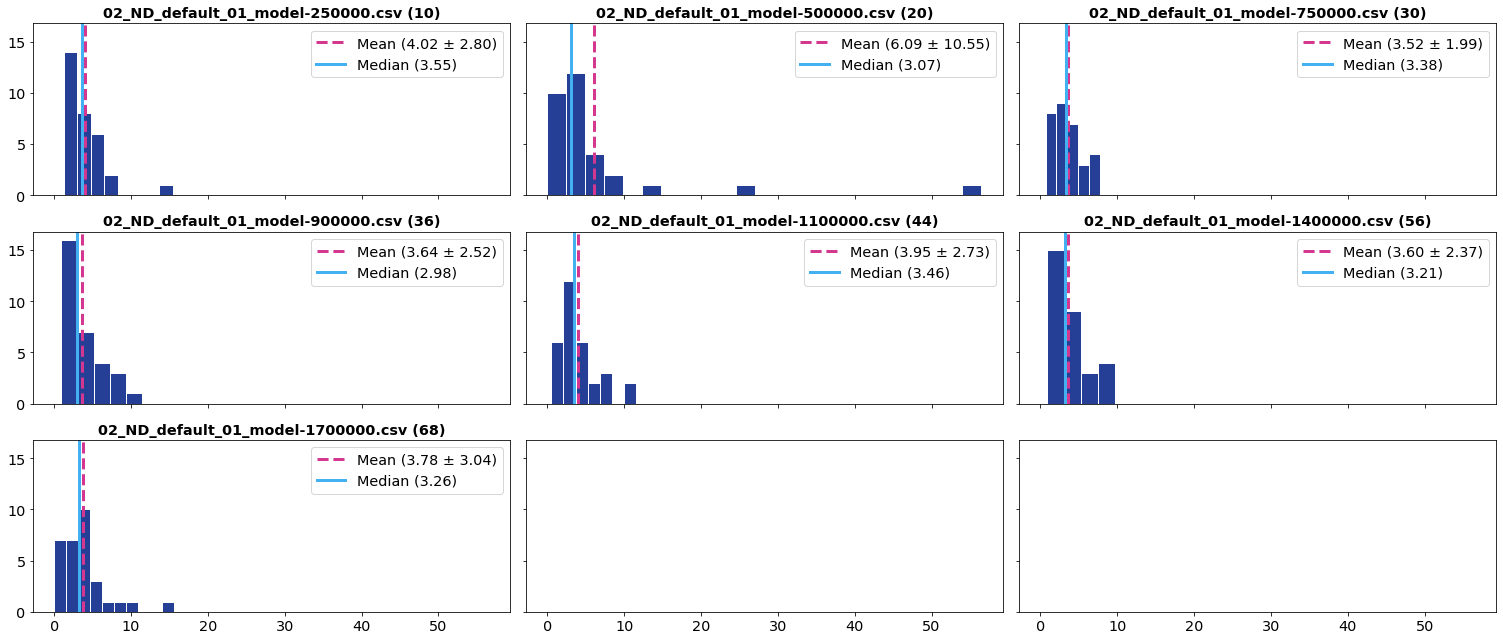

In [27]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

logs = {0:[['00_default_00_model-250000.csv',
            '00_default_00_model-350000.csv',
            '00_default_00_model-700000.csv',
            '00_default_00_model-1250000.csv',
            '00_default_00_model-1500000.csv'],
           
           ['00_spacing4_01_model-250000.csv',
            '00_spacing4_01_model-300000.csv',
            '00_spacing4_01_model-600000.csv',
            '00_spacing4_01_model-950000.csv',
            '00_spacing4_01_model-1200000.csv'],
           
           ['00_ND_default_02_model-250000.csv',
            '00_ND_default_02_model-400000.csv',
            '00_ND_default_02_model-750000.csv',
            '00_ND_default_02_model-950000.csv',
            '00_ND_default_02_model-1050000.csv',
            '00_ND_default_02_model-1550000.csv',
            '00_ND_default_02_model-2050000.csv']
           ],
               
        1:[['01_default_00_model-250000.csv',
            '01_default_00_model-450000.csv',
            '01_default_00_model-500000.csv',
            '01_default_00_model-700000.csv',
            '01_default_00_model-750000.csv',
            '01_default_00_model-850000.csv',
            '01_default_00_model-1000000.csv',
            '01_default_00_model-1100000.csv'],
           
           ['01_ND_default_01_model-250000.csv',
            '01_ND_default_01_model-500000.csv',
            '01_ND_default_01_model-650000.csv',
            '01_ND_default_01_model-1000000.csv',
            '01_ND_default_01_model-1150000.csv',
            '01_ND_default_01_model-1450000.csv',
            '01_ND_default_01_model-1700000.csv',
            '01_ND_default_01_model-1800000.csv']
           ],


        2:[[ '02_default_00_model-250000.csv',
             '02_default_00_model-400000.csv',
            '02_default_00_model-500000.csv',
             '02_default_00_model-550000.csv',
             '02_default_00_model-1000000.csv',
             '02_default_00_model-1100000.csv',
            '02_default_00_model-1250000.csv',
             '02_default_00_model-1350000.csv',
            '02_default_00_model-1450000.csv',
             '02_default_00_model-1550000.csv',
            '02_default_00_model-1700000.csv',
             '02_default_00_model-1750000.csv',
             '02_default_00_model-1850000.csv',
            '02_default_00_model-1950000.csv',
             '02_default_00_model-2100000.csv'],
           
           ['02_ND_default_01_model-250000.csv',
            '02_ND_default_01_model-500000.csv',
            '02_ND_default_01_model-750000.csv',
            '02_ND_default_01_model-900000.csv',
            '02_ND_default_01_model-1100000.csv',
            '02_ND_default_01_model-1400000.csv',
            '02_ND_default_01_model-1700000.csv']
           ]
        }

log_names = logs[num][indx]

columns_num = 3
height_box = int(np.ceil(len(log_names)/columns_num))
figsize = (7*columns_num,min(3*height_box,16))

fig, (axes) = plt.subplots(height_box,columns_num,sharey=True, sharex=True,figsize = figsize )
ax_hist = axes.flat
results = []

barcolor = dark_blue
medcolor= light_blue
meancolor= light_red
logs_filepath = '/content/drive/My Drive/TFM/Data_models_TFM/LAA/Logs/'
dict_results = {}

# Reading the logs:
for it, log_name in enumerate(log_names):
  
  epoch_num = ((int)(log_name.split('-')[1].split('.')[0]))//25000

  results.append(pd.read_csv(logs_filepath+log_name))
  results[it].set_index('idx_num')
  model_mean = results[it]['distance_error'].mean()
  model_std = results[it]['distance_error'].std()
  model_median = results[it]['distance_error'].median()
  model_mean_score = results[it]['score'].median()
  model_max_dist = results[it]['distance_error'].max() 
  dict_results[f"{epoch_num}"] = [model_mean,model_std,model_median,model_mean_score,model_max_dist]
  
  #Distribution Plot
  sns.distplot(results[it]['distance_error'], ax=ax_hist[it],kde=False,rug=False,norm_hist=False,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1, "rwidth":None,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"}).set_title( log_name + f' ({epoch_num})' ,fontweight='bold')
  ax_hist[it].axvline(model_mean, color=meancolor, linestyle='--',linewidth = 3,label= f'Mean ({model_mean:.2f} \xb1 {model_std:.2f})')
  ax_hist[it].axvline(model_median, color=medcolor, linestyle='-',linewidth = 3,label= f'Median ({model_median:.2f})')
  ax_hist[it].legend()
  ax_hist[it].set(xlabel='')

fig.tight_layout()
plt.show()

,epoch_num,mean_distance,dist_std,dist_median,mean_score,max_distance,weighted_value,cv,esp
0,10,4.0214,2.7982,3.5537,51.3310,15.4034,0.1614,0.6958,34.1791
1,20,6.0877,10.5541,3.0746,56.2488,56.4826,0.0291,1.7337,83.6166
2,30,3.5215,1.9916,3.3818,63.8678,7.7076,0.3684,0.5656,25.3794
3,36,3.6446,2.5199,2.9815,64.0096,11.4721,0.2392,0.6914,25.8926
4,44,3.9488,2.7287,3.4628,48.6062,11.5312,0.2196,0.6910,32.5716
5,56,3.5978,2.3716,3.2069,52.8577,9.7284,0.2857,0.6592,26.7487
6,68,3.7755,3.0432,3.2624,55.5642,15.6101,0.1697,0.8060,32.1733


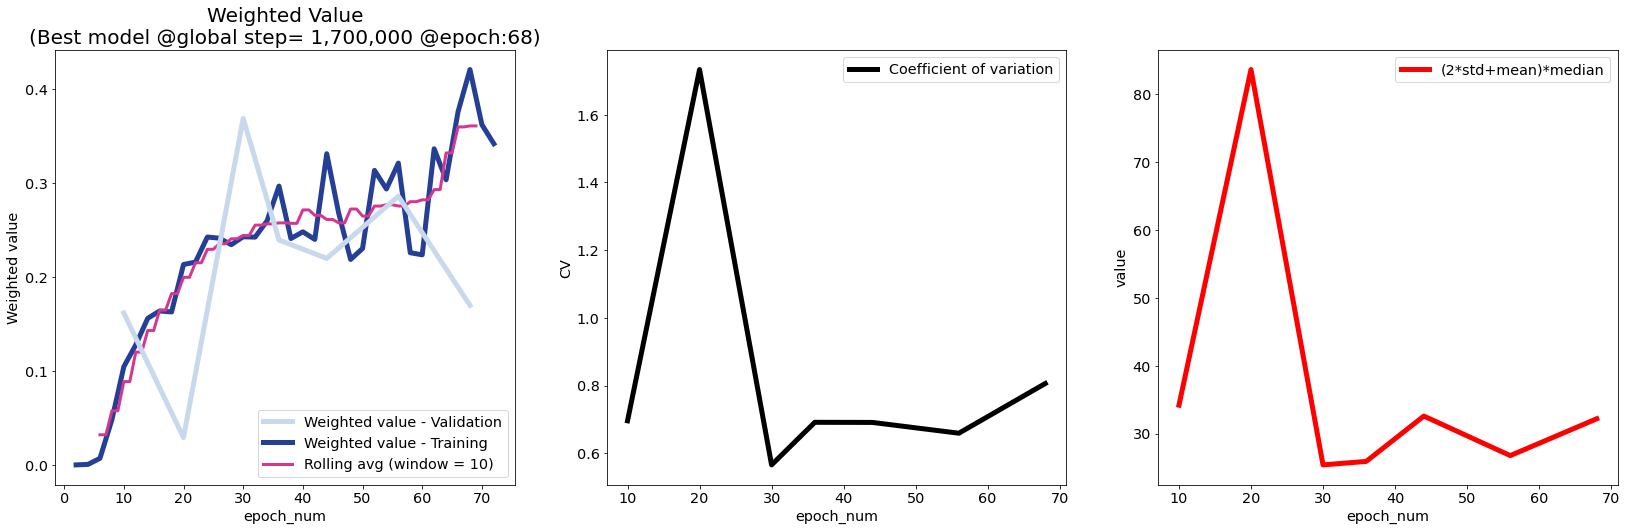

In [28]:
validation_results = pd.DataFrame.from_dict(dict_results,orient='index', columns=['mean_distance', 'dist_std','dist_median','mean_score','max_distance'])
validation_results['weighted_value'] =  validation_results.apply(lambda row: \
                                      10/((row.mean_distance)*(row.max_distance)), axis=1)
validation_results['cv'] = validation_results.apply(lambda row: (row.dist_std/row.mean_distance), axis=1)
validation_results['esp'] = validation_results.apply(lambda row: ((2*row.dist_std+row.mean_distance)*row.dist_median), axis=1)
validation_results.index.name = "epoch_num"
validation_results= validation_results.reset_index().astype({'epoch_num': 'int64'})

fig, (ax,ax_pres,ax_esp) = plt.subplots(1,3,figsize = (28,8) )
sns.lineplot(data=validation_results,x="epoch_num",y="weighted_value",ax= ax,color = lighter_blue, zorder = -3, linewidth = 5,label = f'Weighted value - Validation')
sns.lineplot(x="epoch_num", y="weighted_value", data=my_df,ax= ax,color = dark_blue, zorder = -5, linewidth = 5,label = f'Weighted value - Training')
sns.lineplot(x="epoch_num", y="rolling_w_v", data=my_df,ax= ax,
          color = light_red,linewidth = 3, zorder = -4,linestyle ='--',
          label =f'Rolling avg (window = {windowsize})').set_title(f"Weighted Value\n(Best model @global step= {best_mod.global_step:,.0f} @epoch:{best_mod.epoch_num:.0f})", fontsize=20)
ax.set(ylabel='Weighted value')


sns.lineplot(data=validation_results,x="epoch_num",y="cv",ax= ax_pres,color = 'k', zorder = -3, linewidth = 5,label = f'Coefficient of variation')
ax_pres.set(ylabel='CV')
sns.lineplot(data=validation_results,x="epoch_num",y="esp",ax= ax_esp,color = 'r', zorder = -3, linewidth = 5,label = f'(2*std+mean)*median')
ax_esp.set(ylabel='value')
validation_results

Number of errors =  9 (29.03%)


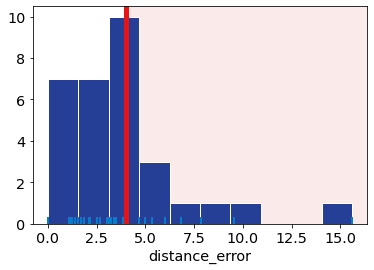

In [29]:
treshold = 4
df_num = -1

errors = results[df_num].loc[results[df_num]['distance_error'] > treshold,:].sort_values(by='distance_error',ascending = False)
hist_ax= sns.distplot(results[df_num]['distance_error'],kde=False,rug=True,norm_hist=False,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"})
hist_ax.axvline(treshold,color = '#EA1313',linewidth = 5)
xlim = hist_ax.get_xlim()
hist_ax.axvspan(treshold, xlim[-1], color='#EF9A9A', alpha=0.2,zorder = -10)
hist_ax.set_xlim(xlim)

print('Number of errors = ', errors.distance_error.size,f'({errors.distance_error.size/results[df_num].distance_error.size:.2%})' )

In [30]:
errors.sort_values(by='distance_error',ascending=True)

,idx_num,filename,score,distance_error,final_coordinates_x,final_coordinates_y,final_coordinates_z,target_x,target_y,target_z,spacing_x,spacing_y,spacing_z
9,10,Bordeaux_Case173,15.4529,4.1366,129,127,193,125,130,188,0.7148,0.7148,0.5626
13,14,Bordeaux_Case206,43.5046,4.6554,147,118,210,144,120,204,0.7500,0.7500,0.6316
7,8,Bordeaux_Case163,50.2284,4.9718,125,125,200,120,120,200,0.7031,0.7031,0.5262
24,25,denmark_A11,27.4963,5.3208,145,151,186,150,152,192,0.8580,0.8580,0.5246
16,17,Bordeaux_Case3,44.4987,5.9913,135,149,215,137,144,221,0.9219,0.9219,0.5590
14,15,Bordeaux_Case25,63.0670,6.8082,123,156,224,128,154,237,0.9023,0.9023,0.3974
20,21,Bordeaux_Case7,52.7795,7.8378,146,168,146,133,168,145,0.6523,0.6523,0.3885
4,5,Bordeaux_Case14,62.3230,9.5366,129,150,226,132,150,204,0.9922,0.9922,0.4118
18,19,Bordeaux_Case45,67.8056,15.6101,122,144,242,135,144,223,0.9141,0.9141,0.5328


### [Validation] Final Results

,N,Mínimo,Máximo,Media,Desv. típ.,mean + 2*sD,mean - 2*sD
Landmark,,,,,,,
1,31,0.6992,30.2595,8.8798,8.1938,-7.5079,25.2674
2,31,0.9180,12.6228,5.2447,3.3342,-1.4237,11.9132
3,31,0.6523,7.7076,3.5215,1.9916,-0.4618,7.5048


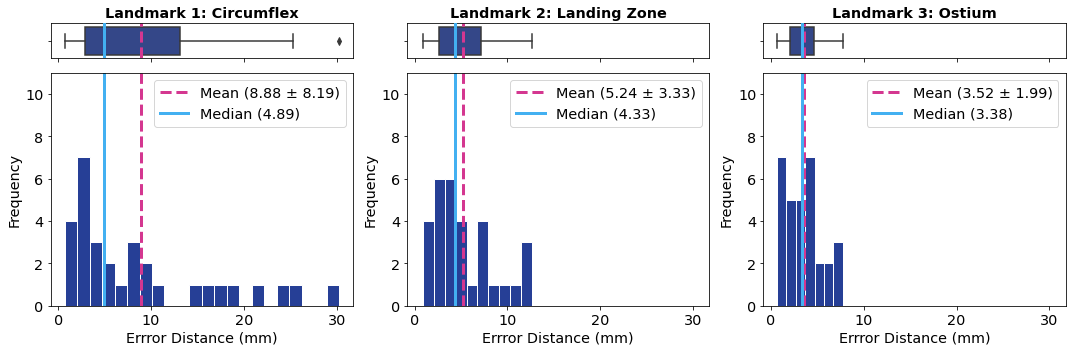

In [31]:
dict_best = {0:'00_ND_default_02_model-1550000.csv',1:'01_ND_default_01_model-1000000.csv',2:'02_ND_default_01_model-750000.csv'}
columns =['Landmark','N','Mínimo','Máximo','Media','Desv. típ.']
performance = pd.DataFrame(columns =columns)
numcol = 3
fig, (axes) = plt.subplots(ncols=numcol, nrows=2,sharex=True, gridspec_kw= {"height_ratios": [0.15, 1] },figsize = (15,5))
axes= axes.flat
results = []
barcolor = "#263f96"
medcolor= '#43B0F1'
meancolor= '#D43790'
count =0
bins_val = [22,10,7]

for lm_ind, log_name in dict_best.items():

  results.append(pd.read_csv(logs_filepath+log_name))
  results[lm_ind].set_index('idx_num')
  mean = results[lm_ind]['distance_error'].mean()
  std = results[lm_ind]['distance_error'].std()
  median=results[lm_ind]['distance_error'].median()
  max_dist = results[lm_ind]['distance_error'].max()
  min_dist = results[lm_ind]['distance_error'].min()
  to_append = pd.DataFrame( {'Landmark':[lm_ind+1],'N':[len(results[lm_ind].index)],'Mínimo':[min_dist],'Máximo':[max_dist],'Media':[mean],'Desv. típ.':[std]})  
  performance = performance.append(to_append)

  axes[lm_ind+count].axvline(median, color=medcolor,linewidth = 3, linestyle='-',zorder = 10)
  axes[lm_ind+count].axvline(mean, color=meancolor,linewidth = 3, linestyle='--')    
  sns.boxplot(results[lm_ind]['distance_error'], ax=axes[lm_ind+count], color =barcolor)
  axes[lm_ind+count].set(xlabel='')
  axes[lm_ind+count].set_title( f"Landmark {lm_ind+1}: {lm_names[lm_ind]}"  ,fontweight='bold')

  sns.distplot(results[lm_ind]['distance_error'], ax=axes[lm_ind+count+numcol],kde=False,rug=False,norm_hist=False,bins= bins_val[lm_ind],\
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"})
  axes[lm_ind+count+numcol].set(xlabel='Errror Distance (mm)', ylabel='Frequency')
  axes[lm_ind+count+numcol].axvline(mean, color=meancolor, linestyle='--',linewidth = 3,label= f'Mean ({mean:.2f} \xb1 {std:.2f})')
  axes[lm_ind+count+numcol].axvline(median, color=medcolor, linestyle='-',linewidth = 3,label= f'Median ({median:.2f})')
  axes[lm_ind+count+numcol].legend()
  axes[lm_ind+count+numcol].set(ylim=(0, 11))
  #count += 3*(lm_ind%2)
fig.tight_layout()
#Compute table values
def f1(x):
  return x[4] + 2*x[5] 
def f2(x):
  return x[4] - 2*x[5]
performance['mean + 2*sD'] = performance.apply(f2 , axis=1)
performance['mean - 2*sD'] = performance.apply(f1 , axis=1)
performance.set_index('Landmark', inplace=True)
performance

## TESTING

### [Testing] Final Results

,N,Mínimo,Máximo,Media,Desv. típ.,mean + 2*sD,mean - 2*sD
Landmark,,,,,,,
1,16,1.6945,25.7974,12.0394,8.5909,-5.1424,29.2212
2,16,1.9548,8.9778,4.3188,2.2892,-0.2596,8.8973
3,16,0.4885,5.5759,2.9205,1.3426,0.2352,5.6058


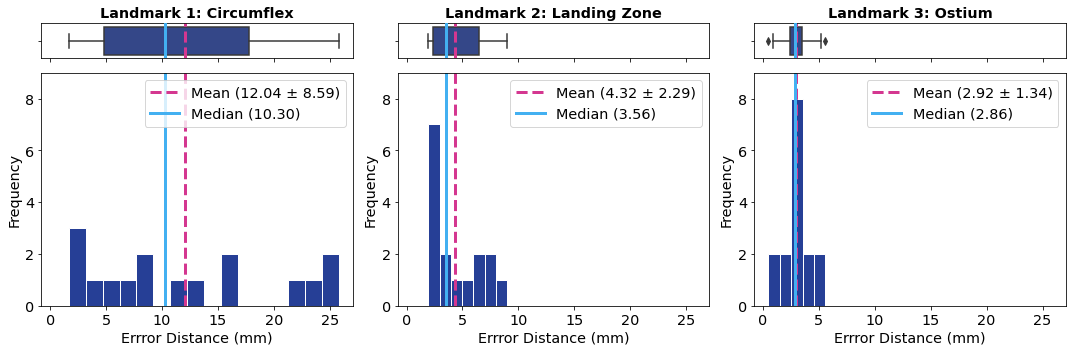

In [32]:
dict_best = {0:'landmark_0_test_model-1550000.csv',1:'landmark_1_test_model-1000000.csv',2:'landmark_2_test_model-750000.csv'}
columns =['Landmark','N','Mínimo','Máximo','Media','Desv. típ.']
performance = pd.DataFrame(columns =columns)
numcol = 3
fig, (axes) = plt.subplots(ncols=numcol, nrows=2,sharex=True, gridspec_kw= {"height_ratios": [0.15, 1] },figsize = (15,5))
axes= axes.flat
results = []
barcolor = "#263f96"
medcolor= '#43B0F1'
meancolor= '#D43790'
count =0
bins_val = [16,7,5]

for lm_ind, log_name in dict_best.items():

  results.append(pd.read_csv(logs_filepath+log_name))
  results[lm_ind].set_index('idx_num')
  mean = results[lm_ind]['distance_error'].mean()
  std = results[lm_ind]['distance_error'].std()
  median=results[lm_ind]['distance_error'].median()
  max_dist = results[lm_ind]['distance_error'].max()
  min_dist = results[lm_ind]['distance_error'].min()
  to_append = pd.DataFrame( {'Landmark':[lm_ind+1],'N':[len(results[lm_ind].index)],'Mínimo':[min_dist],'Máximo':[max_dist],'Media':[mean],'Desv. típ.':[std]})  
  performance = performance.append(to_append)

  axes[lm_ind+count].axvline(median, color=medcolor,linewidth = 3, linestyle='-',zorder = 10)
  axes[lm_ind+count].axvline(mean, color=meancolor,linewidth = 3, linestyle='--')    
  sns.boxplot(results[lm_ind]['distance_error'], ax=axes[lm_ind+count], color =barcolor)
  axes[lm_ind+count].set(xlabel='')
  axes[lm_ind+count].set_title( f"Landmark {lm_ind+1}: {lm_names[lm_ind]}"  ,fontweight='bold')

  sns.distplot(results[lm_ind]['distance_error'], ax=axes[lm_ind+count+numcol],kde=False,rug=False,norm_hist=False,bins= bins_val[lm_ind],\
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"})
  axes[lm_ind+count+numcol].set(xlabel='Errror Distance (mm)', ylabel='Frequency')
  axes[lm_ind+count+numcol].axvline(mean, color=meancolor, linestyle='--',linewidth = 3,label= f'Mean ({mean:.2f} \xb1 {std:.2f})')
  axes[lm_ind+count+numcol].axvline(median, color=medcolor, linestyle='-',linewidth = 3,label= f'Median ({median:.2f})')
  axes[lm_ind+count+numcol].legend()
  axes[lm_ind+count+numcol].set(ylim=(0, 9))
  #count += 3*(lm_ind%2)
fig.tight_layout()
#Compute table values
def f1(x):
  return x[4] + 2*x[5] 
def f2(x):
  return x[4] - 2*x[5]
performance['mean + 2*sD'] = performance.apply(f2 , axis=1)
performance['mean - 2*sD'] = performance.apply(f1 , axis=1)
performance.set_index('Landmark', inplace=True)
performance